In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

random.seed(10)

In [2]:
# Hidden state space
S = [0, 1]
# Emission space
V = [1, 2, 3, 4, 5]
# Transition matrix
A = np.matrix([[0.8, 0.2], 
               [0.1, 0.9]])
# Initial distribution 
mu_0 = [0.5, 0.5]
# Emission matrix
B = np.matrix([[0.2, 0.5, 0.2, 0.1, 0],
               [0, 0.1, 0.4, 0.4, 0.1]])

In [239]:
def writeParametersToFile(S, V, A, mu_0, B, file):
    # Write parameters to file
    f = open(file, "w")
    f.write("State space: " + " ".join(str(s) for s in S) + "\n")
    f.write("Emission space: " + " ".join(str(v) for v in V) + "\n")
    f.write("Transition matrix: " + " ".join(str(a) for a in np.array(A).flatten()) + "\n")
    f.write("Initial distribution: " + " ".join(str(m) for m in mu_0) + "\n")
    f.write("Emission matrix: " + " ".join(str(b) for b in np.array(B).flatten()))
    f.close()

In [247]:
class HMM():
    """
    S: state space
    V: emission space
    A: transition matrix
    mu_0: initial distribution
    B: emission matrix
    N: markov chain length
    """
    
    def __init__(self, S = None, V = None, A = None, mu_0 = None, B = None,
                 N = 100, file = None):
        
        if isinstance(file, type(None)):
            # If no file given, directly set parameters
            self.S = S
            self.V = V
            self.A = A
            self.mu_0 = mu_0
            self.B = B
            
        else:
            # Otherwise read parameters from a file
            f = open(file, "r")
            
            readArray = lambda x: np.array(x.readline().split()[2:]).astype(float)
            readMatrix = lambda x: np.matrix(x.readline().split()[2:]).astype(float)

            self.S = readArray(f)
            self.V = readArray(f)
            self.A = readMatrix(f)
            self.A.shape = (len(self.S), len(self.S))
            self.mu_0 = readArray(f)
            self.B = readMatrix(f)
            self.B.shape = (len(self.S), len(self.V))
            
        # Set the chain length
        self.N = N
        
        # Create the markov chain
        self.markov_chain = self.markovChain()
        # Get the emitted states
        self.emission = self.emitStates()
        
        self.forwardAlgorithm(self.emission)
        
    def markovChain(self):
        # Create markov chain
        chain = np.zeros(self.N)
        # Set the first state by sampling from the initial distribution
        chain[0] = np.random.choice(self.S, p = self.mu_0)
        
        # Set the remaining states in the chain
        for i in range(1, self.N):
            # Get the probability row from the transition matrix
            state_prob = np.array(self.A[int(chain[i - 1])]).flatten()
            # Sample from the state space
            chain[i] = np.random.choice(self.S, p = state_prob)
        
        return(chain)
    
    def emitStates(self):
        emission = np.zeros(self.N)
        
        for i in range(self.N):
            # Get the probability row from the emission matrix
            emit_prob = np.array(self.B[int(self.markov_chain[i])]).flatten()
            # Sample from the emission matrix
            emission[i] = np.random.choice(self.V, p = emit_prob)
            
        return(emission)
    
    # Scaled forward algorithm
    def forwardAlgorithm(self, sequence):
        alphas = np.zeros(len(sequence))
        
        c_0 = self.B
        print(sequence[0])
        alphas[0] = 

In [248]:
hmm = HMM(file = "hmm_params.txt", N = 115)
states = hmm.markov_chain
values = hmm.emission



3.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


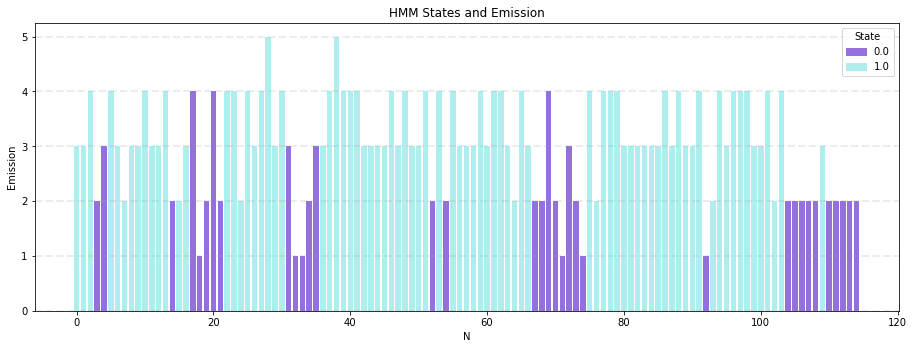

In [237]:
colour_dict = {0: "red", 1: "darkorange", 2: "yellow", 3: "greenyellow", 4: "purple"}
colour_dict = {0: "mediumpurple", 1: "paleturquoise", 2: "yellow", 3: "greenyellow", 4: "purple"}

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar([i for i in range(len(values))], values, color = [colour_dict[int(s)] for s in states])
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.2)
plt.title('HMM States and Emission')
plt.xlabel('N')
plt.ylabel('Emission')

plt.legend(handles = [mpatches.Patch(color = colour_dict[i],
                                     label = np.unique(states)[i]) for i in range(len(np.unique(states)))],
           title = "State")
#plt.savefig(".pdf", bbox_inches = 'tight')
plt.show()